# Predicting Heart Disease

### Scenario

>The World Health Organization (WHO) estimates that 17.9 million people die from cardiovascular diseases (CVDs) every year.
>
>There are multiple risk factors that could contribute to CVD in an individual, such as unhealthy diet, lack of physical activity, or mental illness. Identifying these risk factors early on could help prevent many premature deaths.
>
>We are working for an R&D company that focuses on providing healthcare solutions. The company has collected anonymized data from multiple hospitals on several patients. The dataset includes relevant information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before.

\- From the guided project's [Introduction section](https://app.dataquest.io/c/134/m/740/guided-project%3A-predicting-heart-disease/1/introduction?path=2&slug=data-scientist&version=1)

### Goal

Predict the likelihood of a new patient having heart disease in the future. 

### Results

We were able to increase the model performance on both the training set and the test set by tuning the hyperparameters and adding cross-validation, correctly diagnosing 47 patients with no heart disease and 75 patients with heart disease out of 138 patients in the test set with 88.41% accuracy.

Strongest correlations:
- 392 (79%) of 496 patients with asymptomatic (ASY) chest pain have heart disease
- 316 (85%) of 371 patients with exercise-induced angina have heart disease
- 170 (79%) of 214 patients with fasting blood sugar above 120 mg/dl have heart disease
- 381 (83%) of 460 patients with flat ST slope have heart disease

79% of the dataset contained male patients. By reducing this disparity in the dataset so the gender distribution is equal, we can further reduce bias and increase the performance of the model. 

## Table of Contents
- Import the libraries
- Import the data
- Explore the data
    - Descriptive statistics
    - Categorical data
- Clean the data
- Feature selection
- Split the dataset
- One-hot encoding
- Feature scaling
- Build the model
- Tune the model
- Evaluate the model on the test set

## Import the libraries

In [45]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import ipywidgets as widgets
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

%matplotlib inline
sns.set_theme(style="whitegrid")
plt.rcParams["font.family"] = "arial"

np.random.seed(1)

## Import the data

In [2]:
heart_data = pd.read_csv("heart_disease_prediction.csv")
X = heart_data.iloc[:, :-1].values
y = heart_data.iloc[:, -1].values

## Explore the data

The dataset has the following features:
>
>- `Age`: age of the patient [years]
>- `Sex`: sex of the patient [M: Male, F: Female]
>- `ChestPainType`: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
>- `RestingBP`: resting blood pressure [mm Hg]
>- `Cholesterol`: serum cholesterol [mm/dl]
>- `FastingBS`: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
>- `RestingECG`: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
>- `MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]
>- `ExerciseAngina`: exercise-induced angina [Y: Yes, N: No]
>- `Oldpeak`: oldpeak = ST [Numeric value measured in depression]
>- `ST_Slope`: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
>- `HeartDisease`: output class [1: heart disease, 0: Normal]

\- From the guided project's [Introduction section](https://app.dataquest.io/c/134/m/740/guided-project%3A-predicting-heart-disease/1/introduction?path=2&slug=data-scientist&version=1)

### Descriptive statistics

In [3]:
heart_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
heart_data.shape

(918, 12)

In [5]:
heart_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


The data appears to be clean with no missing values and the columns classified appropriately as either numerical or categorical.

In [6]:
heart_describe = heart_data.describe()
heart_describe

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [7]:
mean_lower = heart_describe.loc["mean", "Age"] - heart_describe.loc["std", "Age"]
mean_upper = heart_describe.loc["mean", "Age"] + heart_describe.loc["std", "Age"]
print(f"Average patient age range: ({round(mean_lower)}, {round(mean_upper)})")

Average patient age range: (44, 63)


In [8]:
cholesterol_median = heart_describe.loc["50%", "Cholesterol"]
cholesterol_mean = heart_describe.loc["mean", "Cholesterol"]
skew_direction = cholesterol_median - cholesterol_mean
print(f"Skewness direction: {round(skew_direction,2)}")

Skewness direction: 24.2


Quick observations:
- The average age of patients in this dataset is 53 years old. Give or take 9.43 years, patients are between 44 and 63 years old on average. 
- The median for `Cholesterol` is higher than the mean by about `223-198.8 = 24.2 mm/dl`, indicating a left-skewed distribution.
- `RestingBP` and `Cholesterol` have a minimum value of 0. These values are highly unlikely and may just represent missing data so we'll need to address these columns.
- `FastingBS` uses categorical numbers `0` and `1`.

### Categorical data

The categorical data include columns of the `object` datatype: 
- Sex
- ChestPainType
- RestingECG
- ExerciseAngina
- ST_Slope

Because FastingBS and HeartDisease both contain only binary values `0` and `1`, we classify these also as categorical data.

In [9]:
categorical_cols = heart_data.select_dtypes(include=["object"]).columns
print(categorical_cols)

Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')


In [10]:
binary_cols = ["FastingBS", "HeartDisease"]
for col in binary_cols:
    print(f"{col}: {heart_data[col].unique()}")

FastingBS: [0 1]
HeartDisease: [0 1]


In [11]:
categorical_cols.dtype

dtype('O')

In [12]:
categorical_cols = categorical_cols.union(binary_cols)
print(categorical_cols)

Index(['ChestPainType', 'ExerciseAngina', 'FastingBS', 'HeartDisease',
       'RestingECG', 'ST_Slope', 'Sex'],
      dtype='object')


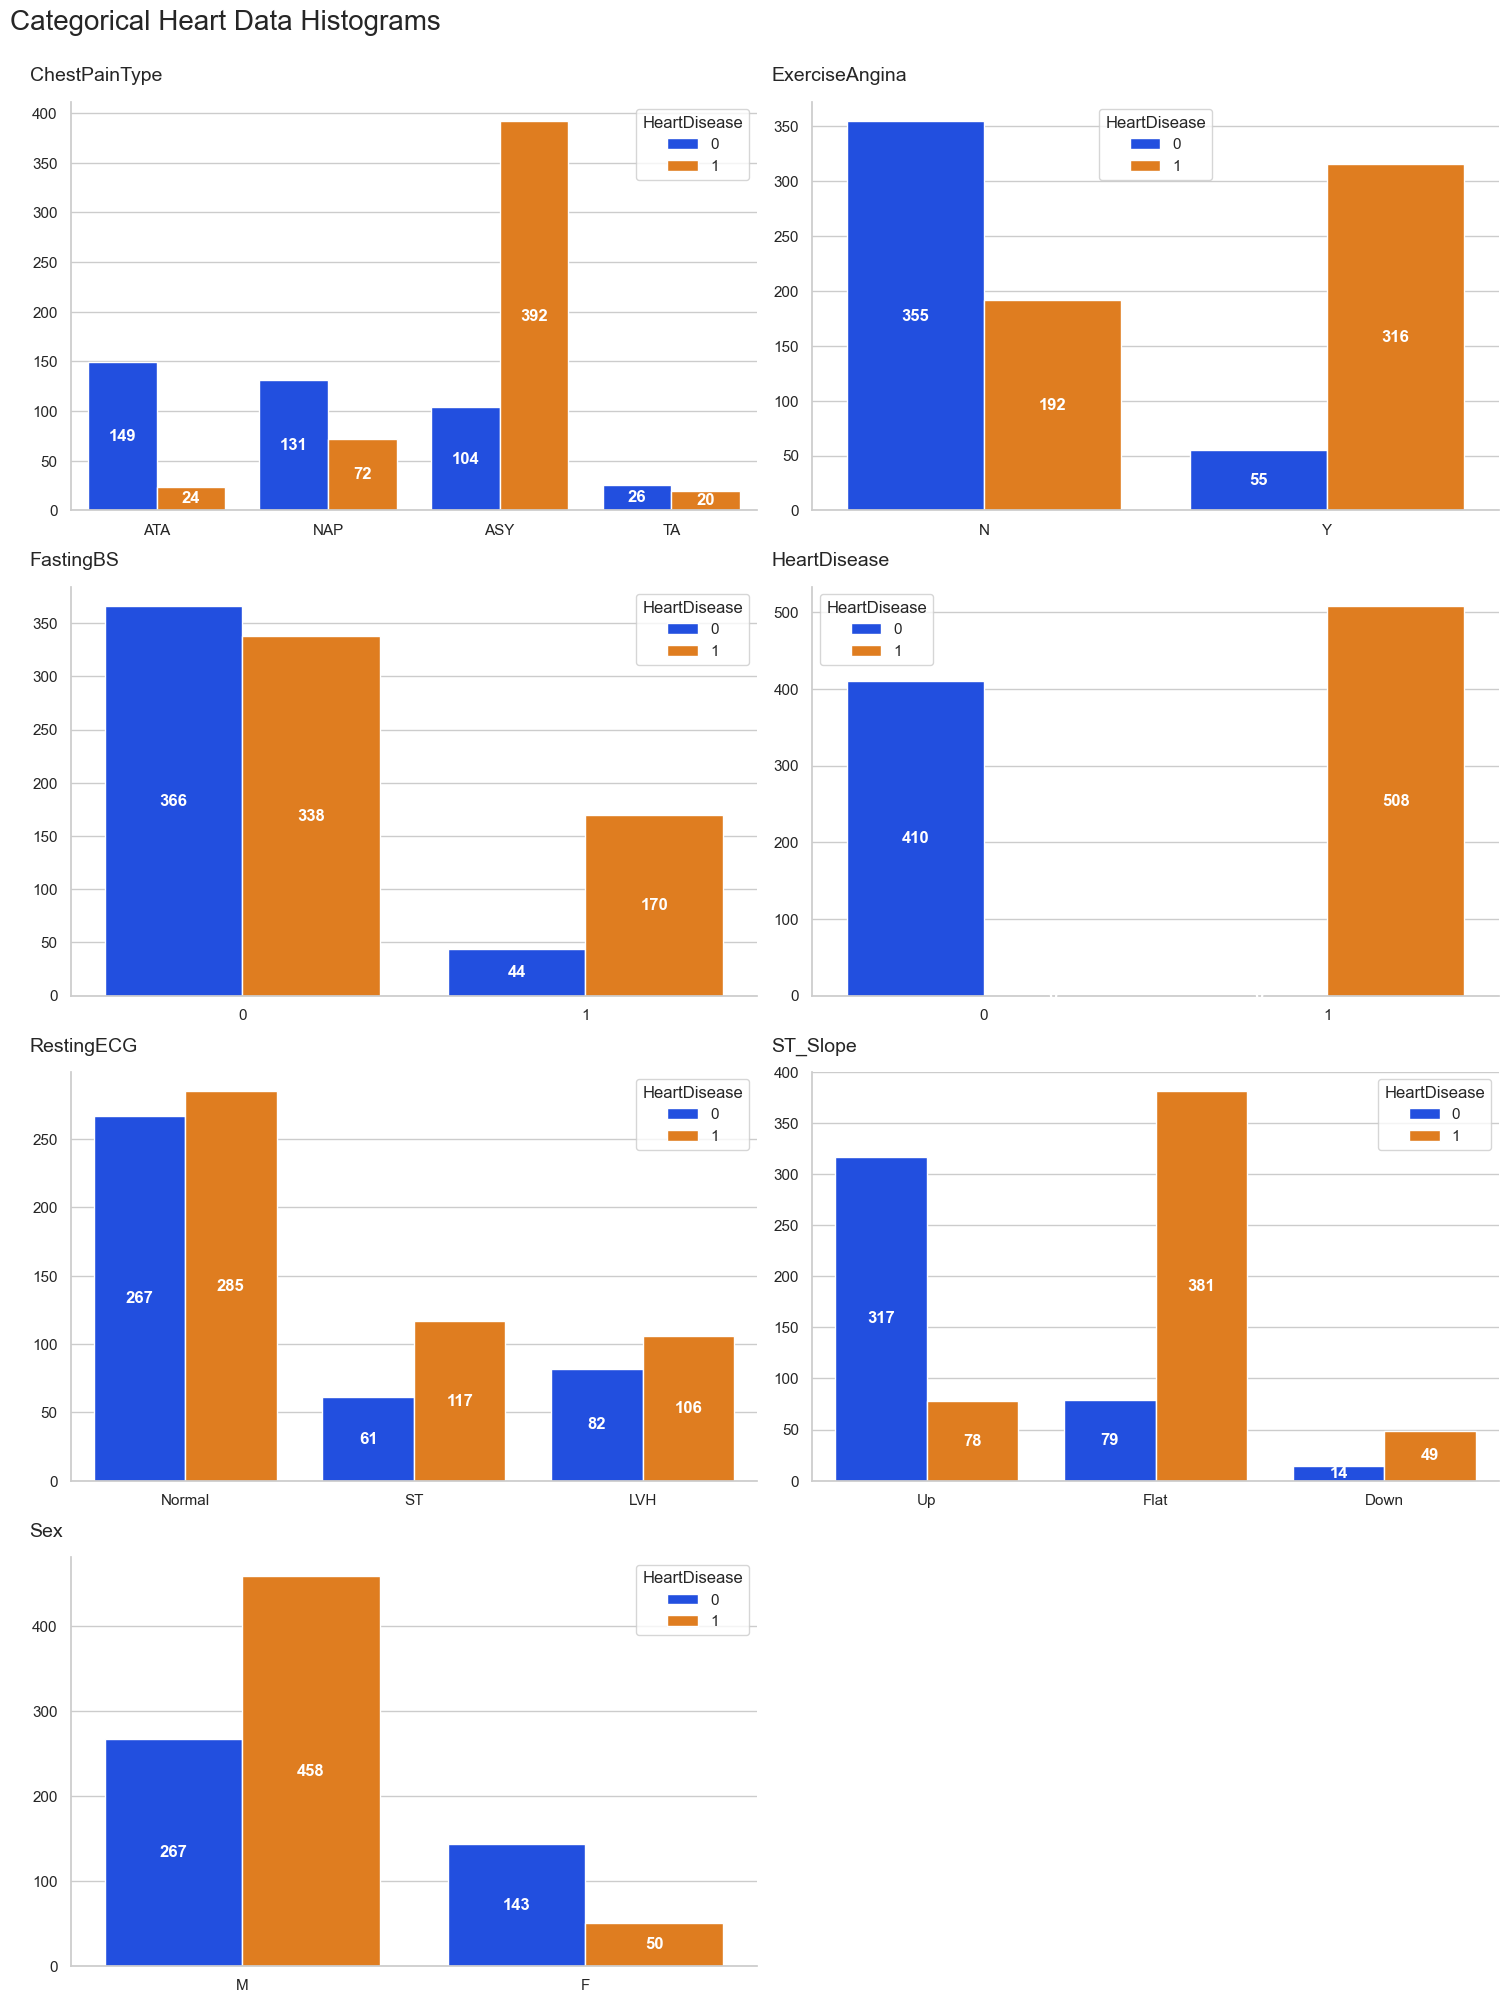

In [13]:
fig = plt.figure(figsize=(15,20))
for index, col in enumerate(categorical_cols):
    ax = plt.subplot(4, 2, index+1)
    sns.countplot(x=heart_data[col], ax=ax, hue=heart_data["HeartDisease"], palette="bright")
    plt.title(label=f"{col}", fontsize=14, loc="left", x=-0.06, y=1.03)
    plt.xlabel("")
    plt.ylabel("")
    sns.despine()
    for container in ax.containers:
        ax.bar_label(container, label_type="center", fontsize=12, fontweight="bold", color="white")
plt.suptitle("Categorical Heart Data Histograms", fontsize=20, x= 0.14, y=1)
plt.tight_layout(pad=1.0)

In [14]:
for col in categorical_cols:
    print(heart_data[col].value_counts(normalize=True))
    print('-'*30)

ChestPainType
ASY    0.540305
NAP    0.221133
ATA    0.188453
TA     0.050109
Name: proportion, dtype: float64
------------------------------
ExerciseAngina
N    0.595861
Y    0.404139
Name: proportion, dtype: float64
------------------------------
FastingBS
0    0.766885
1    0.233115
Name: proportion, dtype: float64
------------------------------
HeartDisease
1    0.553377
0    0.446623
Name: proportion, dtype: float64
------------------------------
RestingECG
Normal    0.601307
LVH       0.204793
ST        0.193900
Name: proportion, dtype: float64
------------------------------
ST_Slope
Flat    0.501089
Up      0.430283
Down    0.068627
Name: proportion, dtype: float64
------------------------------
Sex
M    0.78976
F    0.21024
Name: proportion, dtype: float64
------------------------------


In [15]:
print(round(392/(392+104),2)) # pop with heart disease / pop with ASY chest pain
print(round(316/(316+55),2)) # pop with heart disease / pop with exercise-induced angina
print(round(170/(170+44),2)) # pop with heart disease / pop with FastingBS > 120 mg/dl
print(round(381/(381+79),2)) # pop with heart disease/ pop with flat ST slope
print(round((458+267)/(267+458+143+50),2)) # males / total dataset pop

0.79
0.85
0.79
0.83
0.79


-  Of the 496 patients who had asymptomatic (ASY) chest pain, 392 (79%) were diagnosed with heart disease.
-  Of those who had exercise-induced angina, 316 (85%) had heart disease. 
-  Of those with high blood sugar (over 120 mg/dl), 170 (79%) had heart disease.
-  The majority of patients without heart disease have an upward ST slope.
-  Of those with a flat ST slope, 381 (83%) had heart disease.
-  The dataset is skewed towards male patients at 79% of the dataset. 

## Clean the data

We identified the minimum values of `RestingBP` and `Cholesterol` were 0. As these are not reasonable plausible, we check these further.

In [16]:
heart_data[heart_data["RestingBP"]==0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [17]:
heart_data[heart_data["Cholesterol"]==0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


The `RestingBP` column has only one zero value. We will remove this row. 

In [18]:
heart_data_new = heart_data.copy()
heart_data_new = heart_data_new[heart_data_new["RestingBP"] != 0]

For the `Cholesterol` column, there are 172 rows with zero values. It is more likely that the zero values represent missing values rather than numerical null values. For these rows, we replace the zero values with the median of the non-zero values in this column.

In [19]:
no_heart_disease = heart_data_new["HeartDisease"]==0

col_cholesterol_no_heart_disease = heart_data_new.loc[no_heart_disease, "Cholesterol"]
col_cholesterol_heart_disease = heart_data_new.loc[~no_heart_disease, "Cholesterol"]

heart_data_new.loc[no_heart_disease, "Cholesterol"] = col_cholesterol_no_heart_disease.replace(to_replace = 0, value = col_cholesterol_no_heart_disease.median())
heart_data_new.loc[~no_heart_disease, "Cholesterol"] = col_cholesterol_heart_disease.replace(to_replace = 0, value = col_cholesterol_heart_disease.median())
heart_data_new[["Cholesterol", "RestingBP"]].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000


The minimum values have now increased from `0` to `85` for `Cholesterol` and `80` for `RestingBP`.

## Feature selection

Recall the categorical columns we identified earlier.

In [20]:
heart_data_new.select_dtypes(include=["object"]).columns

Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object')

In [21]:
heart_data_new["ChestPainType"].value_counts()

ChestPainType
ASY    496
NAP    202
ATA    173
TA      46
Name: count, dtype: int64

In [22]:
categorical_cols

Index(['ChestPainType', 'ExerciseAngina', 'FastingBS', 'HeartDisease',
       'RestingECG', 'ST_Slope', 'Sex'],
      dtype='object')

We have 11 independent variables and one dependent variable, HeartDisease. To get a better sense of how the variables are related to each other, we explore their correlations.

We first convert the categorical columns into dummy variables to be able to produce the correlation matrix.

In [23]:
heart_data_corr = heart_data_new.copy()
heart_data_corr = pd.get_dummies(heart_data_corr, drop_first=False)

<Axes: >

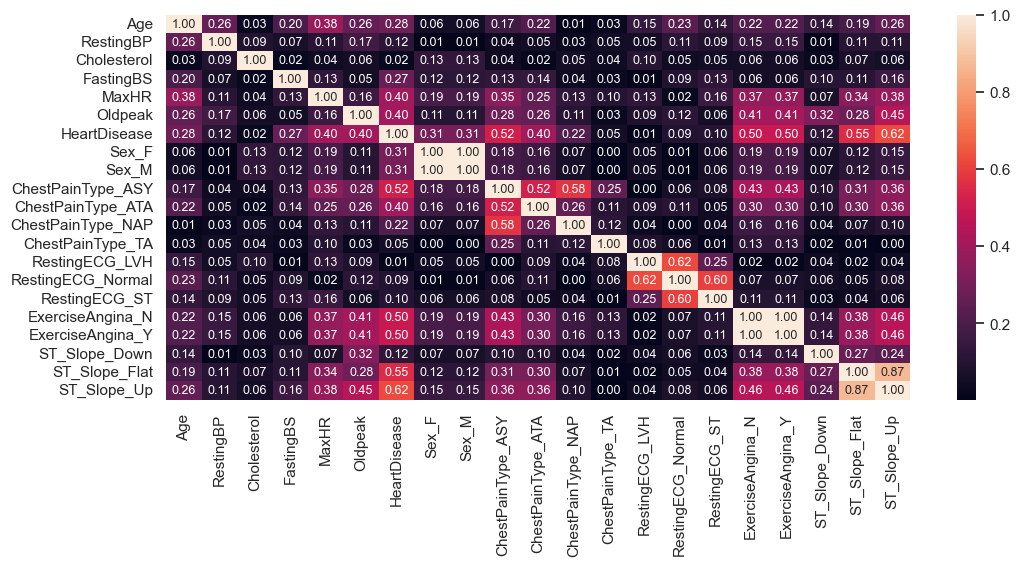

In [24]:
plt.figure(figsize=(12,5))
sns.heatmap(abs(heart_data_corr.corr()), 
            fmt=".2f",
            annot=True, 
            annot_kws={"size": 9})

There are a large number of variables so we focus on the ones with significant correlations, namely those above 0.4.

<Axes: >

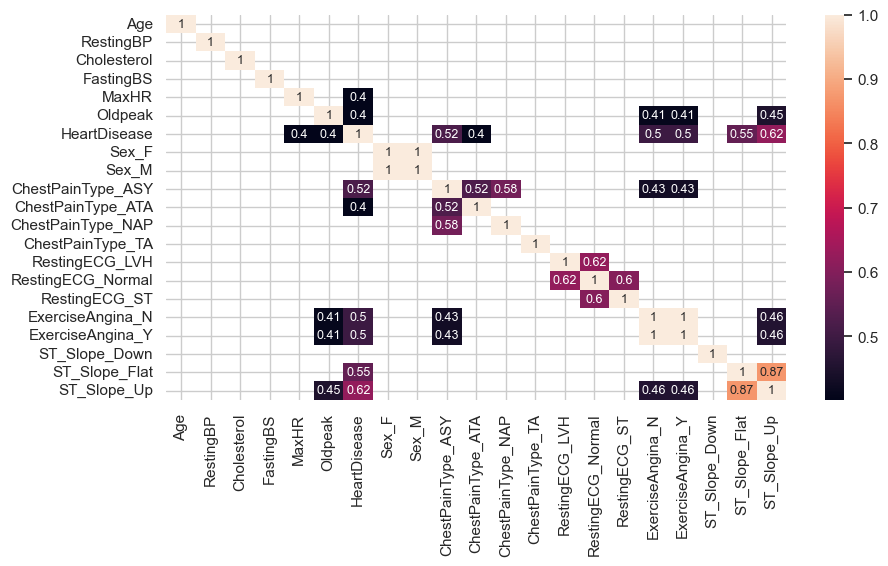

In [25]:
plt.figure(figsize=(10,5))
sns.heatmap(abs(heart_data_corr.corr())[abs(heart_data_corr.corr())>0.4], 
            annot=True, 
            annot_kws={"size": 9})

Looking at the `HeartDisease` row, the variables with correlations greater than or equal to 0.4 are:
- MaxHR: 0.4
- Oldpeak: 0.4
- ChestPainType_ASY: 0.52
- ChestPainType_ATA: 0.4
- ExerciseAngina_Y: 0.5
- ExerciseAngina_N: 0.5
- ST_Slope_Flat: 0.55
- ST_Slope_Up: 0.62

## Split the dataset

We split our dataset into a training and a test set.

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)

## One-hot encoding

We apply one hot encoding to the categorical columns of the dataset X containing our independent variables. Since the target variable "HeartDisease" is binary (0 or 1), we will not need to apply one hot encoding to dataset y.

In [27]:
heart_data_new.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

In [28]:
heart_data_features = heart_data_new.drop("HeartDisease", axis=1)
cat_features = heart_data_features.columns
print(cat_features)

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
      dtype='object')


In [29]:
cat_indices = [i for i, cat in enumerate(cat_features) if cat in categorical_cols]
print(cat_indices)

[1, 2, 5, 6, 8, 10]


In [30]:
ct = ColumnTransformer(
    transformers=[
        ("encoder", OneHotEncoder(), cat_indices)], remainder="passthrough")
X_train = ct.fit_transform(X_train)
X_val = ct.transform(X_val)

## Feature scaling

To compare the features appropriately to each other, we normalize them first.

In [31]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

## Build the model

In [32]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train_scaled, y_train)
train_accuracy = knn.score(X_train_scaled, y_train)
print(f"Model accuracy on training set: {train_accuracy*100:.2f}%")
test_accuracy = knn.score(X_val_scaled, y_val)
print(f"Model accuracy on test set: {test_accuracy*100:.2f}%")

Model accuracy on training set: 90.13%
Model accuracy on test set: 84.06%


The k-NN classifier with two nearest neighbors produces 90% accuracy on the training set but 84% on the test set. Because we selected a nearest neighbor size of 2, the high model accuracy on the training set is most likely due to overfitting. To obtain a more accurate performance of our model, we optimize the hyperparameters.

## Tune the model

Using grid search, we explore the following hyperparameters:
- `n` = `1` through `20` neighbors
- the `minkowski` and `manhattan` distance metrics

We also simultaneously use cross validation to find the optimal number of cross-validation folds.
- `k` = `2` through `20` folds

In [33]:
knn = KNeighborsClassifier()
grid_params = {"n_neighbors": range(1, 21),
               "metric": ["minkowski", "manhattan"]
              }
fold_values = range(2, 21)

mean_scores = {}
max_score = 0.0
best_fold_value = 0
best_n_neighbors = 0
for fold_value in fold_values:
    kf = KFold(n_splits = fold_value, shuffle=True)
    knn_grid = GridSearchCV(knn, grid_params, scoring="accuracy", cv=kf)
    knn_grid.fit(X_train_scaled, y_train)
    best_params = knn_grid.best_params_
    best_score = knn_grid.best_score_
    mean_scores[fold_value]={"n": best_params["n_neighbors"], "best_score": best_score}
    
    if best_score > max_score:
        max_score = best_score
        best_fold_value = fold_value
        best_n_neighbors = best_params["n_neighbors"]
        best_metric = best_params["metric"]
        
print(f"Best k-folds: {best_fold_value}, Best n-neighbors: {best_n_neighbors}, Best score: {max_score*100:.2f}%, Best metric: {best_metric}")

Best k-folds: 11, Best n-neighbors: 13, Best score: 87.57%, Best metric: manhattan


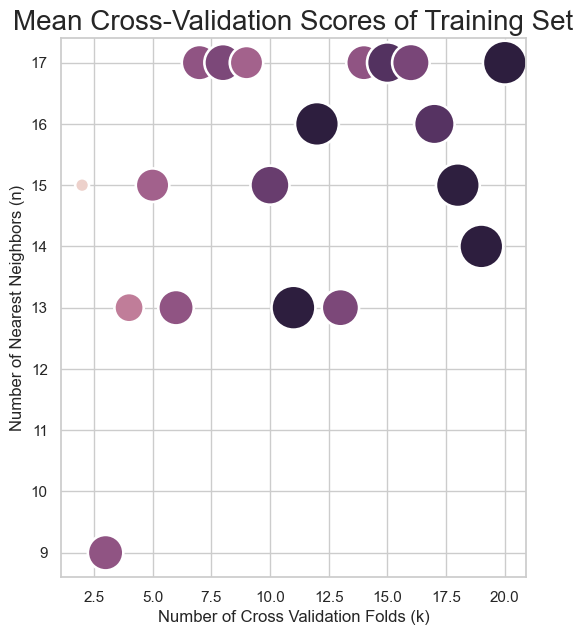

In [34]:
x_values = []
y_values = []
sizes = []

for fold_value, scores in mean_scores.items():
    x_values.append(fold_value)
    y_values.append(scores["n"])
    sizes.append(scores["best_score"])

plt.figure(figsize=(6, 7))
sns.scatterplot(x=x_values, y=y_values, hue=sizes, size=sizes, sizes=(100, 1000), legend=False)
plt.xlabel("Number of Cross Validation Folds (k)")
plt.ylabel("Number of Nearest Neighbors (n)")
plt.title("Mean Cross-Validation Scores of Training Set", fontsize=20)
plt.grid(True)
plt.show()

We print all scores close to the max score of 87.57% to verify our optimal model for the training set has the following parameters:
- k = 11 cross-validation folds
- n = 13 nearest neighbors
- metric = Manhattan

In [38]:
for fold_value, nested_dict in mean_scores.items():
    n_neighbors = nested_dict["n"]
    score = nested_dict["best_score"]
    if score > max_score-0.005:
        print(f"k: {fold_value}, n: {n_neighbors}, best score: {score*100:.2f}%")

k: 10, n: 15, best score: 87.18%
k: 11, n: 13, best score: 87.57%
k: 12, n: 16, best score: 87.56%
k: 15, n: 17, best score: 87.31%
k: 17, n: 16, best score: 87.29%
k: 18, n: 15, best score: 87.56%
k: 19, n: 14, best score: 87.56%
k: 20, n: 17, best score: 87.56%


It appears that a minimum of 10 cross-validation folds produces scores close to the max score of 87.57% for the training set.

## Evaluate the model on the test set

Using the tuned parameters above, we instantiate the optimal k-NN model.

In [39]:
knn_best = KNeighborsClassifier(n_neighbors=best_n_neighbors, metric=best_metric)
knn_best.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=13)

In [40]:
X_val_scaled = scaler.transform(X_val)
predictions = knn_best.predict(X_val_scaled)
accuracy = accuracy_score(y_val, predictions)
print(f" Model accuracy on test set: {accuracy*100:.2f}%")

 Model accuracy on test set: 88.41%


By tuning the model, we increase the model accuracy on the test set from 84.06% to 88.41%.

In [43]:
len(X_val)

138

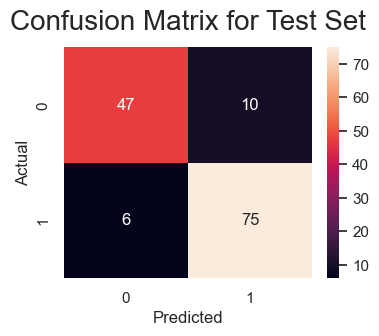

In [42]:
cm = confusion_matrix(y_val, predictions)
names = [0, 1]

plt.figure(figsize=(4, 3))
sns.heatmap(cm, 
            annot=True, 
            fmt='d',
            xticklabels=names, 
            yticklabels=names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Test Set', fontsize=20, y=1.04)
plt.show()